### 1. Un projet complet

L'archive [`imdb_smol.tar.gz`](data/imdb_smol.tar.gz) (aussi disponible [dans le
dépôt](https://github.com/LoicGrobol/apprentissage-artificiel/blob/main/slides/06-scikit-learn/data/imdb_smol.tar.gz))
contient 602 critiques de films sous formes de fichiers textes, réparties en deux classes :
positives et négatives (matérialisées par des sous-dossiers). Votre mission est de réaliser un
script qui :

- Charge et vectorise ces données
- Entraîne et compare des classifieurs sur ce jeu de données

L'objectif est de déterminer quel type de vectorisation et de modèle semble le plus adapté et quels
hyperparamètres choisir. Vous pouvez par exemple tester des SVM comme ci-dessus, [un modèle de
régression
logistique](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
[un arbre de
décision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html),
[un modèle bayésien
naïf](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) ou
[une forêt d'arbres de
décision](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [31]:
# Load libraries
import os
import nltk
import string
import re
import pandas as pd
import numpy as np
from sklearn import metrics
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm
tqdm.pandas()

# Set seed
np.random.seed(500)

# Package specific installs
nltk.download('stopwords')
nltk.download('punkt')

# CONSTANTS
LANG = 'english' # change for model to work on other languages (may still need to update nltk and spacy_sentence_bert)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
#load drive path 
from google.colab import drive
drive.mount('/content/drive')
data = defaultdict(list)
path = ['/content/drive/MyDrive/Projet ML/DM perso/neg', '/content/drive/MyDrive/Projet ML/DM perso/pos']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#loading the data in a dataframe and labeling
for i in path:
    for filename in os.listdir(i):
        with open(os.path.join(i, filename), 'r') as f:
            data['Text'].append(f.read())
            if i == path[0]:
                data['Polarity'].append('Negative')
            else:
                data['Polarity'].append('Positive')
df = pd.DataFrame(data)
print(df)

                                                  Text  Polarity
0    This is really a new low in entertainment. Eve...  Negative
1    SWING! is an important film because it's one o...  Negative
2    This video nasty was initially banned in Brita...  Negative
3    I have been looking for this film for ages bec...  Negative
4    The original book of this was set in the 1950s...  Negative
..                                                 ...       ...
597  I came in in the middle of this film so I had ...  Positive
598  As a study of the frailties of human nature in...  Positive
599  I guess if a film has magic, I don't need it t...  Positive
600  Fair drama/love story movie that focuses on th...  Positive
601  "Gespenster" (2005) forms, together with "Yell...  Positive

[602 rows x 2 columns]


In [34]:
#cleaning the data

def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

df["Text"] = df["Text"].apply(clean_text)

print(df) 

                                                  Text  Polarity
0    really new low entertainment even though lot w...  Negative
1    swing important film one remaining blackproduc...  Negative
2    video nasty initially banned britain allowed l...  Negative
3    looking film ages quite rare find one video na...  Negative
4    original book set wont tv series people watch ...  Negative
..                                                 ...       ...
597  came middle film idea credits even title till ...  Positive
598  study frailties human nature context old age f...  Positive
599  guess film magic dont need fluid seamless skip...  Positive
600  fair dramalove story movie focuses lives blue ...  Positive
601  gespenster forms together yella jerichow gespe...  Positive

[602 rows x 2 columns]


In [36]:
#dataframe shape : rows and columns
print(df.shape)

(602, 2)


In [38]:
#assigning the heads
X = df['Text']
y = df['Polarity']

In [39]:
# using the train test split function to split the data
X_train, X_test, y_train, y_test = train_test_split(
  X, y , random_state=104,test_size=0.25, shuffle=True)

In [40]:
# visualising the split of the data
print('X_train : ')
print(X_train.head())
print(X_train.shape)

print('')
print('X_test : ')
print(X_test.head())
print(X_test.shape)
 
print('')
print('y_train : ')
print(y_train.head())
print(y_train.shape)
 
print('')
print('y_test : ')
print(y_test.head())
print(y_test.shape)

X_train : 
47     films pick pound turn rather good rd century f...
81     warning review contains spoilers read dont wan...
273    mann photographs alberta rocky mountains super...
448    im male given womens movies really well done s...
360    peter bogdonavich made handful truly great fil...
Name: Text, dtype: object
(451,)

X_test : 
169    possible spoilerbr br return cabin lake useles...
546    lars von triers europa extremely good film how...
566    seen trailer movie several times say ned kelly...
547    movie great teenager friends love series goes ...
381    excellent piece puppet series film showed seri...
Name: Text, dtype: object
(151,)

y_train : 
47     Negative
81     Negative
273    Negative
448    Positive
360    Positive
Name: Polarity, dtype: object
(451,)

y_test : 
169    Negative
546    Positive
566    Positive
547    Positive
381    Positive
Name: Polarity, dtype: object
(151,)


In [41]:
# the dataframe cleaned
train_df = pd.DataFrame(data={"x_train":X_train, "y_train":y_train})
test_df = pd.DataFrame(data={"x_test":X_test, "y_test":y_test})
print(train_df.head())
print(test_df.head())

                                               x_train   y_train
47   films pick pound turn rather good rd century f...  Negative
81   warning review contains spoilers read dont wan...  Negative
273  mann photographs alberta rocky mountains super...  Negative
448  im male given womens movies really well done s...  Positive
360  peter bogdonavich made handful truly great fil...  Positive
                                                x_test    y_test
169  possible spoilerbr br return cabin lake useles...  Negative
546  lars von triers europa extremely good film how...  Positive
566  seen trailer movie several times say ned kelly...  Positive
547  movie great teenager friends love series goes ...  Positive
381  excellent piece puppet series film showed seri...  Positive


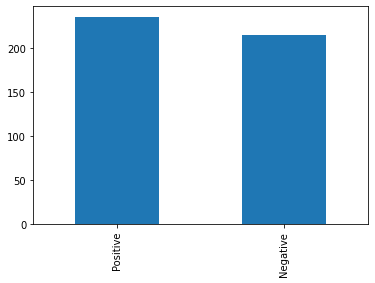

In [43]:
#pos and negs at the y_train data
train_df['y_train'].value_counts().plot.bar()

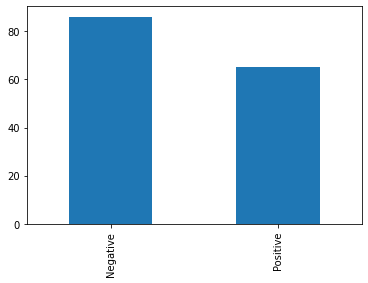

In [44]:
#pos and negs at the y_test data
test_df['y_test'].value_counts().plot.bar()

In [45]:
# shuffle the DataFrame rows
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
# Drop Na
train_df = train_df.dropna()
test_df = test_df.dropna()

# Tokenize via vectorization
train_df["x_train_tokens"] = train_df["x_train"].apply(word_tokenize)
test_df["x_test_tokens"] =   test_df["x_test"].apply(word_tokenize)

# Remove stop words
def remove_stop_words(tokens):
  for token in tokens:
      if token in stopwords.words(LANG):
          tokens.remove(token)
  return tokens
train_df["x_train_cleaned"] = train_df["x_train_tokens"].progress_apply(remove_stop_words)
test_df["x_test_cleaned"] = test_df["x_test_tokens"].progress_apply(remove_stop_words)

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [47]:
#visualising the train dataframe
train_df.head()

,x_train,y_train,x_train_tokens,x_train_cleaned
281,thought newyork located movie wrong little bri...,Negative,"[thought, newyork, located, movie, wrong, litt...","[thought, newyork, located, movie, wrong, litt..."
272,yes indeed could good movie love biangle sorry...,Negative,"[yes, indeed, could, good, movie, love, biangl...","[yes, indeed, could, good, movie, love, biangl..."
593,home room came total surprise clue paid big ti...,Positive,"[home, room, came, total, surprise, clue, paid...","[home, room, came, total, surprise, clue, paid..."
404,busy amazing loved every word ever done freaks...,Positive,"[busy, amazing, loved, every, word, ever, done...","[busy, amazing, loved, every, word, ever, done..."
11,saw premiere melbournebr br shallow twodimensi...,Negative,"[saw, premiere, melbournebr, br, shallow, twod...","[saw, premiere, melbournebr, br, shallow, twod..."


In [48]:
#visualising the test dataframe
test_df.head()

,x_test,y_test,x_test_tokens,x_test_cleaned
309,word classic thrown around loosely nowadays mo...,Positive,"[word, classic, thrown, around, loosely, nowad...","[word, classic, thrown, around, loosely, nowad..."
578,ok musical pieces poorly written generally poo...,Positive,"[ok, musical, pieces, poorly, written, general...","[ok, musical, pieces, poorly, written, general..."
454,protocol hitandmiss picture starring goldie ha...,Positive,"[protocol, hitandmiss, picture, starring, gold...","[protocol, hitandmiss, picture, starring, gold..."
123,big fan arnold vosloo finally seeing star rece...,Negative,"[big, fan, arnold, vosloo, finally, seeing, st...","[big, fan, arnold, vosloo, finally, seeing, st..."
10,constructed one kind fantasy man snowy river m...,Negative,"[constructed, one, kind, fantasy, man, snowy, ...","[constructed, one, kind, fantasy, man, snowy, ..."


In [50]:
#installing bert
!pip install spacy_sentence_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# loading one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
import spacy_sentence_bert
nlp = spacy_sentence_bert.load_model('en_stsb_distilbert_base')

In [52]:
# converting list of strings to strings, to allow for vectorization
def list_to_string(s):
    # initialize an empty string
    str1 = " "
    # return string 
    return (str1.join(s))
train_df["x_train_final"] = train_df["x_train_cleaned"].apply(list_to_string)
test_df["x_test_final"] = test_df["x_test_cleaned"].apply(list_to_string)

In [53]:
#vectorization
def vectorize(string):
  return nlp(string).vector
train_df["x_train_vector"] = train_df["x_train_final"].progress_apply(vectorize)
test_df["x_test_vector"] = test_df["x_test_final"].progress_apply(vectorize)

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [54]:
# dataframe cleaned + the vectorized column 
print(type(train_df["x_train_final"][0]))
print(train_df["x_train_final"][0])
train_df.head()

<class 'str'>
really new low entertainment even though lot worse movies outbr br gangster drug scene genre hard convincing storyline movies mean sebastians motives example couldnt far fetched worn cliché would also need setting character relationships believable movie br br sure tristan drawn away family whats deal father ask permission go age interesting picture though ask lack need rebellious behavior kids upper class family movie go direction even though would potential judging random backflashes wasnt already br br interesting questions brought solid socially critic drama movie focusing cool production techniques special effects giving characters moment reflect forcing story along path want paying attention let story breath naturally evolve br br wants drama glorify abuse substances violence would political incorrect days wouldnt hand nothing cheap action movie like many average set actors vinnie jones managing totally ruin whats left reputation always doesbr br cant recommend itbr

,x_train,y_train,x_train_tokens,x_train_cleaned,x_train_final,x_train_vector
281,thought newyork located movie wrong little bri...,Negative,"[thought, newyork, located, movie, wrong, litt...","[thought, newyork, located, movie, wrong, litt...",thought newyork located movie wrong little bri...,"[0.16448087, 0.29781672, 0.6964226, -0.2850157..."
272,yes indeed could good movie love biangle sorry...,Negative,"[yes, indeed, could, good, movie, love, biangl...","[yes, indeed, could, good, movie, love, biangl...",yes indeed could good movie love biangle sorry...,"[0.28585023, 0.44422752, 0.30931386, -0.068829..."
593,home room came total surprise clue paid big ti...,Positive,"[home, room, came, total, surprise, clue, paid...","[home, room, came, total, surprise, clue, paid...",home room came total surprise clue paid big ti...,"[0.086060375, 0.108763665, 0.15607296, -0.3875..."
404,busy amazing loved every word ever done freaks...,Positive,"[busy, amazing, loved, every, word, ever, done...","[busy, amazing, loved, every, word, ever, done...",busy amazing loved every word ever done freaks...,"[0.771654, 0.41187978, 0.87109655, 0.21429926,..."
11,saw premiere melbournebr br shallow twodimensi...,Negative,"[saw, premiere, melbournebr, br, shallow, twod...","[saw, premiere, melbournebr, br, shallow, twod...",saw premiere melbournebr br shallow twodimensi...,"[0.19115616, 0.149609, 0.5481004, 0.8199785, -..."


In [55]:
# Support Vector Machine (SVM) Classifer
svm = SVC(gamma='auto', verbose=True) 
svm.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = svm.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

[LibSVM]Our accuracy is: 77.4834%


In [56]:
# Random Forest Classifer
rf = RandomForestClassifier(max_depth=None, random_state=0)
rf.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = rf.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 72.8477%


In [57]:
# Logistic Regression Classifer
lr = LogisticRegression(max_iter=5000)
lr.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = lr.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 74.1722%


In [63]:
# Naive Bayes Classifer
nb = GaussianNB()
nb.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = nb.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 77.4834%


In [64]:
# Decision Tree Classifer 
dtc = DecisionTreeClassifier()
dtc.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = dtc.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 60.9272%


Les meuilleurs classifieurs sont : le SVM Classifier et le Naive Bayes Classifer avec 77.4834% de précision. 